In [ ]:
# Standard Libraries
import pandas as pd
import numpy as np
import json
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder

import os
os.chdir("C:/Users/USER/Desktop/GitHub/PREDICTING-SOIL-MOISTURE-USING-SOIL-TEXTURE-AND-SATELLITE-DATA")

# Load and Explore dataset

## Load Dataset

In [ ]:
DATA_PATH = os.getenv("DATA_PATH", default="data/updated_data.csv")

df = pd.read_csv(DATA_PATH)
df.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt
0,2013-01-03,54.875,9.125,5.0,86.0,9.0,0.454120,0.53
1,2013-01-05,54.875,9.125,5.0,86.0,9.0,0.437102,0.44
2,2013-01-07,54.875,9.125,5.0,86.0,9.0,0.412978,0.42
3,2013-01-08,54.875,9.125,5.0,86.0,9.0,0.378734,0.55
4,2013-01-09,54.875,9.125,5.0,86.0,9.0,0.350740,0.46


In [ ]:
# Write the columns to a configuration file
COLUMN_CONFIG = os.getenv("COLUMN_CONFIG", default="config/columns.json")
with open(COLUMN_CONFIG, "w") as f:
    # Convert the columns to json and write to the file
    columns = {col: df[col].dtype.name for col in df.columns}
    json.dump(columns, f)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321584 entries, 0 to 321583
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   time          321584 non-null  object 
 1   latitude      321584 non-null  float64
 2   longitude     321584 non-null  float64
 3   clay_content  321584 non-null  float64
 4   sand_content  321584 non-null  float64
 5   silt_content  321584 non-null  float64
 6   sm_aux        321584 non-null  float64
 7   sm_tgt        321584 non-null  float64
dtypes: float64(7), object(1)
memory usage: 19.6+ MB


### Dataset Overview

The dataset contains **321,584 rows** and **8 columns**. Below is a summary of the columns:

1. **time**: Timestamps (non-null, object type) representing the date of observation.
2. **latitude**: Latitude of the observation (non-null, float64 type).
3. **longitude**: Longitude of the observation (non-null, float64 type).
4. **clay_content**: Percentage of clay in the soil (non-null, float64 type).
5. **sand_content**: Percentage of sand in the soil (non-null, float64 type).
6. **silt_content**: Percentage of silt in the soil (non-null, float64 type).
7. **sm_aux**: Auxiliary soil moisture measurement (non-null, float64 type).
8. **sm_tgt**: Target soil moisture measurement (non-null, float64 type).

- **No missing values**: All columns have non-null entries.

This dataset is clean and ready for further exploration and preprocessing steps.


In [ ]:
df.shape

(321584, 8)

## Summary Statistics of the Dataset

In [ ]:
df.describe()

,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt
count,321584.000000,321584.000000,321584.00000,321584.000000,321584.000000,321584.000000,321584.000000
mean,50.840357,9.622973,20.88792,39.242963,39.894503,0.194109,0.411891
std,1.646484,3.789899,7.92268,21.846045,15.229785,0.088552,0.110530
min,48.125000,2.125000,4.00000,6.000000,8.000000,-0.038657,0.010000
25%,49.375000,6.625000,13.00000,22.000000,25.000000,0.126050,0.350000
50%,50.875000,9.875000,22.00000,32.000000,44.000000,0.178973,0.420000
75%,52.125000,12.875000,27.00000,61.000000,51.000000,0.257252,0.490000
max,54.875000,15.875000,46.00000,86.000000,72.000000,0.802321,0.600000


### Dataset Summary Statistics

- **Row count**: 321,584  
- **Key observations**:  
  - Soil texture components (`clay_content`, `sand_content`, `silt_content`) range widely with varying distributions.  
  - Target soil moisture (`sm_tgt`) ranges from **0.01** to **0.6**, with a mean of **0.4119**.  
  - Auxiliary soil moisture (`sm_aux`) shows variability, with values ranging from **-0.0387** to **0.8023**.  

These statistics indicate diverse soil properties and moisture levels for analysis.


In [ ]:
df.describe(include = 'object')

,time
count,321584
unique,363
top,2013-08-19
freq,1119


# Data Cleaning and Preprocessing

- Handle missing values, duplicates, and outliers.
- Normalize or scale the features (clay_content, sand_content, etc.).
- Convert time to datetime format and extract relevant features (e.g., year, month).

## Missing Values

In [ ]:
df.isna().sum()

time            0
latitude        0
longitude       0
clay_content    0
sand_content    0
silt_content    0
sm_aux          0
sm_tgt          0
dtype: int64

We can see that there are no missing values in the dataset

## Duplicate Values

In [ ]:
df.duplicated().sum()

0

There are no Duplicate values in the dataset.

## Outliers

In [ ]:
def detect_outliers(df, threshold=1.5):
    """
    Detect outliers in a DataFrame using the IQR method.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): The multiplier for the IQR to define outlier boundaries.
        
    Returns:
        dict: A dictionary with column names as keys and counts of outliers as values.
    """
    # Automatically select numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialize a dictionary to store the count of outliers
    outlier_counts = {}
    
    for col in numeric_cols:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Count the number of outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]
    
    return outlier_counts

# Detect outliers and print counts
outlier_counts = detect_outliers(df)
print("Number of outliers per column:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

Number of outliers per column:
latitude: 0
longitude: 0
clay_content: 0
sand_content: 0
silt_content: 0
sm_aux: 1895
sm_tgt: 6564


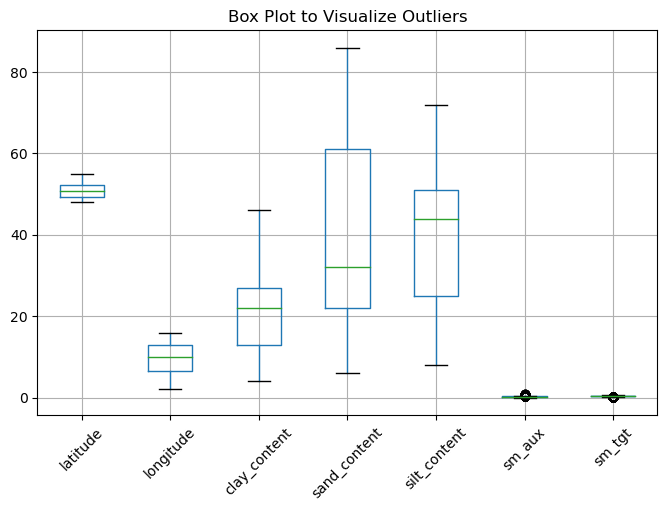

In [ ]:
# Automatically select numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Box plot for each numeric column
df[numeric_cols].boxplot(figsize=(8, 5))
plt.title("Box Plot to Visualize Outliers")
plt.xticks(rotation=45)
plt.show()

We can see alot of Outliers in the `sm_aux` and `sm_tgt` features.

# Feature Engineering

# Modeling
- Define the target (sm_tgt) and features.
- Split data into training, validation, and test sets.
- Train multiple models (e.g., linear regression, random forest, XGBoost).
- Save models to results/model.pkl.

# Evaluation
- Evaluate model performance using metrics like RMSE and R².
- Save evaluation metrics to results/metrics.json.
- Visualize predictions vs. actual values.